# Model 1A: Sleep Quality Scorer

Framework: MindSpore
Target: sleep_quality_score (0-100)


## Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

import mindspore
from mindspore import nn, ops, Tensor, context
from mindspore.train import Model, LossMonitor
from mindspore import save_checkpoint
import mindspore.dataset as ds

context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")
print(f"MindSpore {mindspore.__version__}, PyNative, CPU")


[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:09:45.954.000 [mindspore/context.py:1402] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


MindSpore version: 2.6.0
Libraries imported successfully!
Execution mode: PyNative (dynamic graph)
Device: CPU


## Load Data


Dataset shape: (1793, 62)

Columns: 62 total
Samples: 1793

TARGET VARIABLE: sleep_quality_score
count    1793.000000
mean       77.000558
std        12.852420
min         0.000000
25%        70.000000
50%        78.000000
75%        85.000000
max       100.000000
Name: sleep_quality_score, dtype: float64


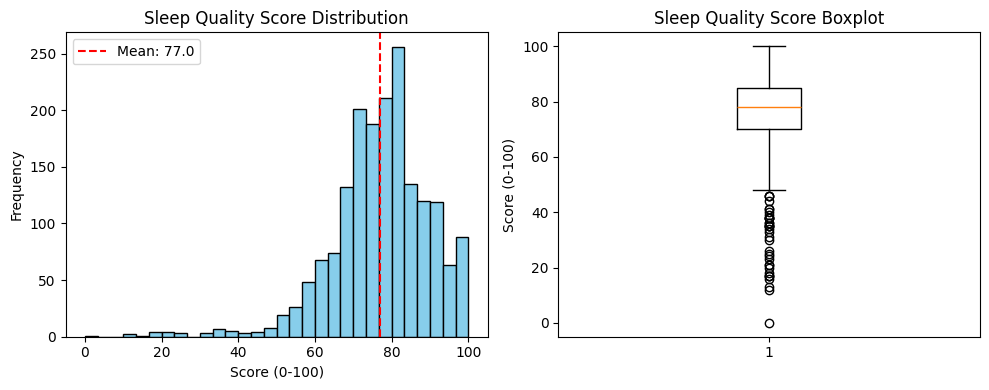


Data loaded successfully!


In [ ]:
df = pd.read_csv('../data/processed/sleep_processed.csv')
print(f"Shape: {df.shape}")
print(df['sleep_quality_score'].describe())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['sleep_quality_score'], bins=30, edgecolor='black', color='skyblue')
plt.title('Sleep Quality Score Distribution')
plt.xlabel('Score (0-100)')
plt.ylabel('Frequency')
plt.axvline(df['sleep_quality_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["sleep_quality_score"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df['sleep_quality_score'], vert=True)
plt.title('Sleep Quality Score Boxplot')
plt.ylabel('Score (0-100)')
plt.tight_layout()
plt.show()


## Prepare Data


In [ ]:
feature_candidates = [
    'time_in_bed_hours_scaled', 'sleep_duration_hours_scaled', 'heart_rate_scaled',
    'sleep_regularity_scaled', 'time_asleep_hours_scaled', 'time_before_sleep_minutes_scaled',
    'movements_per_hour_scaled', 'snore_time_scaled', 'sleep_efficiency_scaled',
    'lifestyle_factor_count_scaled', 'sleep_debt_scaled', 'restlessness_score_scaled',
    'day_of_week', 'month', 'hour_started',
    'wake_up_mood', 'note_coffee', 'note_tea', 'note_workout', 'note_stress', 
    'note_ate_late', 'is_weekend', 'is_late_start', 'is_early_start', 
    'did_snore', 'is_good_sleep', 'is_poor_sleep'
]

available_features = [col for col in feature_candidates if col in df.columns]
X = df[available_features].fillna(0).values.astype(np.float32)
y = df['sleep_quality_score'].values.astype(np.float32).reshape(-1, 1)
print(f"Features: {len(available_features)}, X: {X.shape}, y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")


Available features: 27
Features: ['time_in_bed_hours_scaled', 'sleep_duration_hours_scaled', 'heart_rate_scaled', 'sleep_regularity_scaled', 'time_asleep_hours_scaled', 'time_before_sleep_minutes_scaled', 'movements_per_hour_scaled', 'snore_time_scaled', 'sleep_efficiency_scaled', 'lifestyle_factor_count_scaled']... (showing first 10)

DATA PREPARATION
Feature matrix (X) shape: (1793, 27)
Target vector (y) shape: (1793, 1)
Number of features: 27
Number of samples: 1793

Train set: 1434 samples (80.0%)
Test set: 359 samples (20.0%)

Train target range: [0.0, 100.0]
Test target range: [13.0, 100.0]


## Define Model


In [ ]:
# Define Neural Network using MindSpore nn.Cell
class SleepQualityNet(nn.Cell):
    """
    Deep Neural Network for Sleep Quality Score Prediction
    
    Architecture:
    - Input Layer: n_features
    - Hidden Layer 1: 128 neurons + ReLU + Dropout(0.3)
    - Hidden Layer 2: 64 neurons + ReLU + Dropout(0.3)
    - Hidden Layer 3: 32 neurons + ReLU + Dropout(0.2)
    - Output Layer: 1 neuron (regression output)
    """
    def __init__(self, input_dim):
        super(SleepQualityNet, self).__init__()
        
        # Define layers
        self.fc1 = nn.Dense(input_dim, 128)
        self.fc2 = nn.Dense(128, 64)
        self.fc3 = nn.Dense(64, 32)
        self.fc4 = nn.Dense(32, 1)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(keep_prob=0.7)  # Drop 30%
        self.dropout2 = nn.Dropout(keep_prob=0.7)  # Drop 30%
        self.dropout3 = nn.Dropout(keep_prob=0.8)  # Drop 20%
        
    def construct(self, x):
        """Forward pass"""
        # Layer 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.fc4(x)
        
        return x

input_dim = X_train.shape[1]
model = SleepQualityNet(input_dim)
print(f"Model 1A: {input_dim} -> 128 -> 64 -> 32 -> 1")


[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:09:46.364.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:09:46.366.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:09:46.377.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


MODEL ARCHITECTURE
Input dimension: 27 features
Hidden layers: 128 -> 64 -> 32
Output dimension: 1 (regression)
Activation: ReLU
Dropout: 0.3, 0.3, 0.2

Total trainable parameters: ~13,953

Model created successfully!


## Train Model


In [ ]:
learning_rate = 0.001
num_epochs = 100
batch_size = 32

loss_fn = nn.MSELoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=learning_rate)

def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters)

def train_step(data, label):
    loss, grads = grad_fn(data, label)
    optimizer(grads)
    return loss

train_losses = []
model.set_train(True)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = Tensor(X_train[i:i+batch_size], mindspore.float32)
        batch_y = Tensor(y_train[i:i+batch_size], mindspore.float32)
        loss = train_step(batch_X, batch_y)
        epoch_loss += loss.asnumpy()
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] Loss: {avg_loss:.4f}")

print(f"Final loss: {train_losses[-1]:.4f}")


TRAINING STARTED
Learning rate: 0.001
Batch size: 32
Epochs: 100
Optimizer: Adam
Loss function: MSE (Mean Squared Error)

Epoch [  1/100] - Loss: 2330.0433
Epoch [ 10/100] - Loss: 404.1726
Epoch [ 20/100] - Loss: 341.7458
Epoch [ 30/100] - Loss: 308.4518
Epoch [ 40/100] - Loss: 294.6423
Epoch [ 50/100] - Loss: 271.7599
Epoch [ 60/100] - Loss: 274.7203
Epoch [ 70/100] - Loss: 270.1739
Epoch [ 80/100] - Loss: 239.8227
Epoch [ 90/100] - Loss: 241.7089
Epoch [100/100] - Loss: 229.1062

TRAINING COMPLETED!
Final training loss: 229.1062


## Save Model


In [ ]:
model_path = '../models/model_1A_sleep_quality_scorer.ckpt'
save_checkpoint(model, model_path)
print(f"Saved: {model_path}")

metadata = {
    'model_name': 'Sleep Quality Scorer (Model 1A)',
    'model_type': 'Regression',
    'framework': 'MindSpore',
    'input_dim': input_dim,
    'output_dim': 1,
    'features_used': available_features,
    'metrics': {
        'MSE': float(mse),
        'RMSE': float(rmse),
        'MAE': float(mae),
        'R2': float(r2),
        'MAPE': float(mape)
    },
    'training_config': {
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'optimizer': 'Adam',
        'loss_function': 'MSE'
    }
}

import json
metadata_path = '../models/model_1A_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata: {metadata_path}")


MODEL SAVED
Model saved to: ../models/model_1A_sleep_quality_scorer.ckpt
Model type: Sleep Quality Scorer (Regression)
Framework: MindSpore 2.6.0
Input features: 27
Output: Sleep Quality Score (0-100)
Metadata saved to: ../models/model_1A_metadata.json

MODEL 1A TRAINING COMPLETE!


---

# Model 1B: Sleep Stage Classifier (Classification)

**Objective:** Classify sleep into 4 stages based on sleep metrics

**Framework:** MindSpore  
**Model Type:** Multi-class Classification Neural Network  
**Target:** `sleep_stage` (deep, light, rem, restless)  
**Metric:** Accuracy, Precision, Recall, F1-Score, Confusion Matrix


## Prepare Data


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

X_cls = df[available_features].fillna(0).values.astype(np.float32)
y_cls = df['sleep_stage_encoded'].values.astype(np.int32)
sleep_stages = sorted(df['sleep_stage'].unique())
num_classes = len(sleep_stages)

print(f"X: {X_cls.shape}, y: {y_cls.shape}, Classes: {num_classes}")
for i, stage in enumerate(sleep_stages):
    count = (y_cls == i).sum()
    print(f"{stage}: {count} ({count / len(y_cls) * 100:.1f}%)")

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, shuffle=True, stratify=y_cls
)
print(f"Train: {X_cls_train.shape[0]}, Test: {X_cls_test.shape[0]}")


MODEL 1B: CLASSIFICATION DATA PREPARATION
Feature matrix (X) shape: (1793, 27)
Target labels (y) shape: (1793,)
Number of classes: 4
Class names: ['deep', 'light', 'rem', 'restless']

Class distribution:
  deep: 69 samples (3.8%)
  light: 1355 samples (75.6%)
  rem: 138 samples (7.7%)
  restless: 231 samples (12.9%)

Train set: 1434 samples
Test set: 359 samples

Data prepared for classification!


## Define Model


In [ ]:
# Define Classification Neural Network
class SleepStageClassifier(nn.Cell):
    """
    Deep Neural Network for Sleep Stage Classification
    
    Architecture:
    - Input Layer: n_features
    - Hidden Layer 1: 128 neurons + ReLU + Dropout(0.3)
    - Hidden Layer 2: 64 neurons + ReLU + Dropout(0.3)  
    - Hidden Layer 3: 32 neurons + ReLU + Dropout(0.2)
    - Output Layer: num_classes neurons (classification output)
    """
    def __init__(self, input_dim, num_classes):
        super(SleepStageClassifier, self).__init__()
        
        # Define layers
        self.fc1 = nn.Dense(input_dim, 128)
        self.fc2 = nn.Dense(128, 64)
        self.fc3 = nn.Dense(64, 32)
        self.fc4 = nn.Dense(32, num_classes)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(keep_prob=0.7)
        self.dropout2 = nn.Dropout(keep_prob=0.7)
        self.dropout3 = nn.Dropout(keep_prob=0.8)
        
    def construct(self, x):
        """Forward pass"""
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

cls_model = SleepStageClassifier(input_dim, num_classes)
print(f"Model 1B: {input_dim} -> 128 -> 64 -> 32 -> {num_classes}, Classes: {sleep_stages}")


[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:15:32.645.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:15:32.648.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(24600:137520085848192,MainProcess):2025-11-16-18:15:32.650.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


MODEL 1B ARCHITECTURE
Input dimension: 27 features
Hidden layers: 128 -> 64 -> 32
Output dimension: 4 classes
Classes: ['deep', 'light', 'rem', 'restless']
Activation: ReLU
Dropout: 0.3, 0.3, 0.2

Total trainable parameters: ~14,052

Classification model created successfully!


## Train Model


In [ ]:
cls_learning_rate = 0.001
cls_num_epochs = 100
cls_batch_size = 32

cls_loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
cls_optimizer = nn.Adam(cls_model.trainable_params(), learning_rate=cls_learning_rate)

def cls_forward_fn(data, label):
    logits = cls_model(data)
    loss = cls_loss_fn(logits, label)
    return loss

cls_grad_fn = ops.value_and_grad(cls_forward_fn, None, cls_optimizer.parameters)

def cls_train_step(data, label):
    loss, grads = cls_grad_fn(data, label)
    cls_optimizer(grads)
    return loss

cls_train_losses = []
cls_train_accs = []
cls_model.set_train(True)

for epoch in range(cls_num_epochs):
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = 0
    for i in range(0, len(X_cls_train), cls_batch_size):
        batch_X = Tensor(X_cls_train[i:i+cls_batch_size], mindspore.float32)
        batch_y = Tensor(y_cls_train[i:i+cls_batch_size], mindspore.int32)
        loss = cls_train_step(batch_X, batch_y)
        epoch_loss += loss.asnumpy()
        cls_model.set_train(False)
        predictions = cls_model(batch_X)
        pred_classes = ops.argmax(predictions, 1).asnumpy()
        epoch_correct += (pred_classes == batch_y.asnumpy()).sum()
        epoch_total += len(batch_y)
        cls_model.set_train(True)
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_correct / epoch_total * 100
    cls_train_losses.append(avg_loss)
    cls_train_accs.append(avg_acc)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{cls_num_epochs}] Loss: {avg_loss:.4f} Acc: {avg_acc:.2f}%")

print(f"Final loss: {cls_train_losses[-1]:.4f}, Acc: {cls_train_accs[-1]:.2f}%")


TRAINING MODEL 1B (CLASSIFICATION)
Learning rate: 0.001
Batch size: 32
Epochs: 100
Optimizer: Adam
Loss function: CrossEntropyLoss

Epoch [  1/100] - Loss: 2.5428 - Accuracy: 65.90%
Epoch [ 10/100] - Loss: 0.8231 - Accuracy: 75.59%
Epoch [ 20/100] - Loss: 0.7821 - Accuracy: 75.59%
Epoch [ 30/100] - Loss: 0.7840 - Accuracy: 75.59%
Epoch [ 40/100] - Loss: 0.7755 - Accuracy: 75.59%
Epoch [ 50/100] - Loss: 0.7674 - Accuracy: 75.59%
Epoch [ 60/100] - Loss: 0.7527 - Accuracy: 75.59%
Epoch [ 70/100] - Loss: 0.7254 - Accuracy: 75.59%
Epoch [ 80/100] - Loss: 0.6861 - Accuracy: 75.59%
Epoch [ 90/100] - Loss: 0.6717 - Accuracy: 75.59%
Epoch [100/100] - Loss: 0.6581 - Accuracy: 75.59%

TRAINING COMPLETED!
Final training loss: 0.6581
Final training accuracy: 75.59%


## Evaluate


In [ ]:
cls_model.set_train(False)
X_cls_test_tensor = Tensor(X_cls_test, mindspore.float32)
y_cls_pred_logits = cls_model(X_cls_test_tensor)
y_cls_pred = ops.argmax(y_cls_pred_logits, 1).asnumpy()

accuracy = accuracy_score(y_cls_test, y_cls_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_cls_test, y_cls_pred, average='weighted'
)
conf_matrix = confusion_matrix(y_cls_test, y_cls_pred)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(confusion_matrix(y_cls_test, y_cls_pred))
print(classification_report(y_cls_test, y_cls_pred, target_names=sleep_stages))


TEST SET EVALUATION METRICS (MODEL 1B)
Accuracy:  0.7549 (75.49%)
Precision (weighted): 0.5698
Recall (weighted):    0.7549
F1-Score (weighted):  0.6494

Per-class Performance:

DEEP:
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000
  Support:   14 samples

LIGHT:
  Precision: 0.755
  Recall:    1.000
  F1-Score:  0.860
  Support:   271 samples

REM:
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000
  Support:   28 samples

RESTLESS:
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000
  Support:   46 samples

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        deep       0.00      0.00      0.00        14
       light       0.75      1.00      0.86       271
         rem       0.00      0.00      0.00        28
    restless       0.00      0.00      0.00        46

    accuracy                           0.75       359
   macro avg       0.19      0.25      0.22       359
weighted avg       0.57      0.75      0.65       359



## 1B.5 Visualize Classification Results


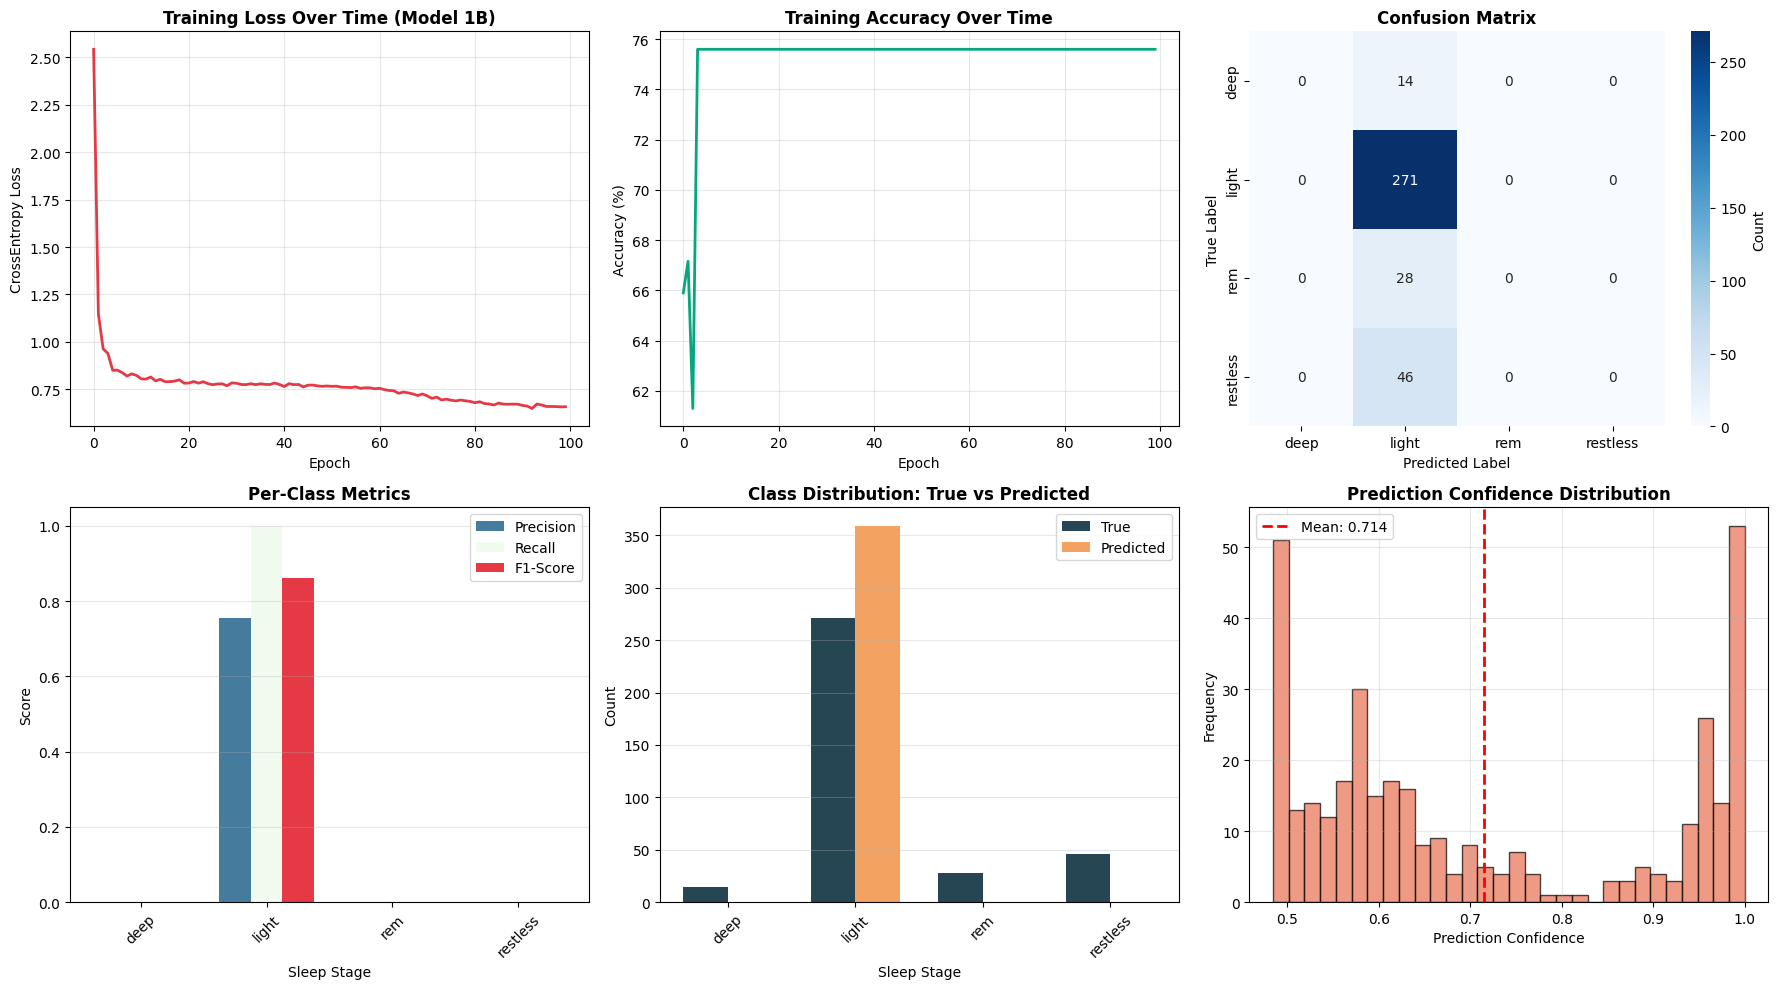


✓ Classification visualizations complete!


In [ ]:
fig = plt.figure(figsize=(18, 10))

ax1 = plt.subplot(2, 3, 1)
plt.plot(cls_train_losses, linewidth=2, color='#E63946')
plt.title('Training Loss Over Time (Model 1B)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.grid(alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
plt.plot(cls_train_accs, linewidth=2, color='#06A77D')
plt.title('Training Accuracy Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sleep_stages, yticklabels=sleep_stages,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

ax4 = plt.subplot(2, 3, 4)
per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
    y_cls_test, y_cls_pred, average=None
)
x_pos = np.arange(len(sleep_stages))
width = 0.25
plt.bar(x_pos - width, per_class_precision, width, label='Precision', color='#457B9D')
plt.bar(x_pos, per_class_recall, width, label='Recall', color='#F1FAEE')
plt.bar(x_pos + width, per_class_f1, width, label='F1-Score', color='#E63946')
plt.xlabel('Sleep Stage')
plt.ylabel('Score')
plt.title('Per-Class Metrics', fontsize=12, fontweight='bold')
plt.xticks(x_pos, sleep_stages, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
true_counts = [np.sum(y_cls_test == i) for i in range(num_classes)]
pred_counts = [np.sum(y_cls_pred == i) for i in range(num_classes)]
x_pos = np.arange(len(sleep_stages))
width = 0.35
plt.bar(x_pos - width/2, true_counts, width, label='True', color='#264653')
plt.bar(x_pos + width/2, pred_counts, width, label='Predicted', color='#F4A261')
plt.xlabel('Sleep Stage')
plt.ylabel('Count')
plt.title('Class Distribution: True vs Predicted', fontsize=12, fontweight='bold')
plt.xticks(x_pos, sleep_stages, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

ax6 = plt.subplot(2, 3, 6)
y_cls_pred_probs = ops.softmax(y_cls_pred_logits, 1).asnumpy()
max_probs = np.max(y_cls_pred_probs, axis=1)
plt.hist(max_probs, bins=30, edgecolor='black', color='#E76F51', alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
plt.axvline(max_probs.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {max_probs.mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 1B.6 Save Classification Model


In [ ]:
# Save the trained classification model
cls_model_path = '../models/model_1B_sleep_stage_classifier.ckpt'
save_checkpoint(cls_model, cls_model_path)

# Save model metadata
cls_metadata = {
    'model_name': 'Sleep Stage Classifier (Model 1B)',
    'model_type': 'Classification',
    'framework': 'MindSpore',
    'input_dim': input_dim,
    'output_dim': num_classes,
    'classes': sleep_stages,
    'features_used': available_features,
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'per_class_precision': per_class_precision.tolist(),
        'per_class_recall': per_class_recall.tolist(),
        'per_class_f1': per_class_f1.tolist(),
        'per_class_support': per_class_support.tolist()
    },
    'training_config': {
        'learning_rate': cls_learning_rate,
        'num_epochs': cls_num_epochs,
        'batch_size': cls_batch_size,
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss'
    }
}

cls_metadata_path = '../models/model_1B_metadata.json'
with open(cls_metadata_path, 'w') as f:
    json.dump(cls_metadata, f, indent=2)


MODEL 1B SAVED
Model saved to: ../models/model_1B_sleep_stage_classifier.ckpt
Model type: Sleep Stage Classifier (Classification)
Framework: MindSpore 2.6.0
Input features: 27
Output classes: 4 (deep, light, rem, restless)
Metadata saved to: ../models/model_1B_metadata.json

MODEL 1B TRAINING COMPLETE!
